# Elbow Method

## Overview

In our last lab, we generated clusters using the K-Means algorithm, but were left with a problem.  How are we to know how many clusters there *should* be in our data?  Obviously, there are many cases where we will have no idea.  After all, if we already knew how many clusters there should be, we would likely skip clustering completely and move on to some other kind of analysis.

So, then, our question can be transformed: "Given some set of data, how can we algorithmically determine how many clusters appear to be present so that we can generate a useful clustering visualization or analysis?"  This brings us to the Elbow Method.

## Goals

In this lab, we will:

* Learn how to implement the elbow method
* Examine ways to algorithmically determine the number of clusters based on the elbow method approach

 
## Estimated Time: 30 minutes

Since our focus is in understanding and applying the elbow method rather than on some new clustering approach, we will cheat a little bit in this lab.

# <img src="../images/task.png" width=20 height=20> Task 2.1

Please begin by copying the relevant portions of the last lab into the following cell to accomplish the following:

* Read the data into a dataframe
* Clean the data
* Perform a $\mathbb{R}^3$ Principal Component Analysis
* Generate the 3d scatter plot of the data

/tmp/ipykernel_8317/839358952.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8, \


554476
85084
642165
11
38224
Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


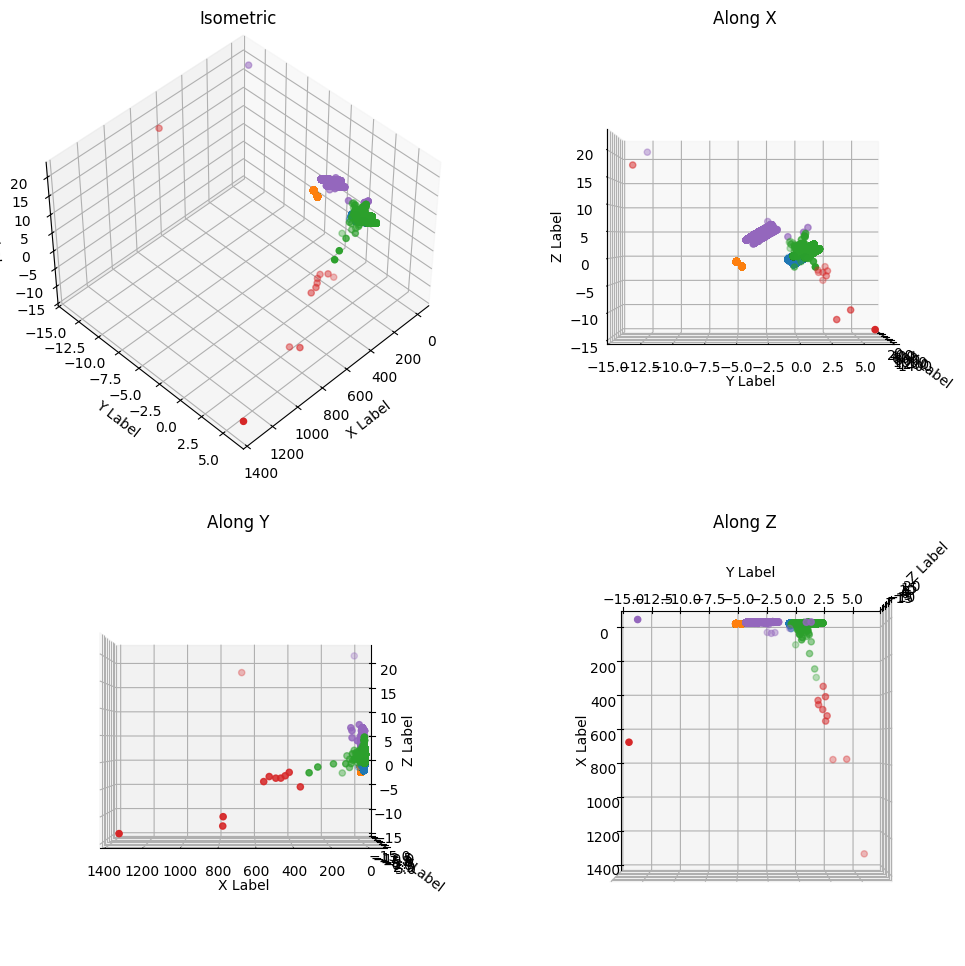

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8, \
        names=['timestamp','uid','src','sport','dst','dport','proto','service','duration','orig_bytes', \
               'resp_bytes','conn_state','local_orig','local_resp','missed_bytes','history','orig_pkts', \
               'orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents'])
df = pd.concat([df, pd.get_dummies(df['proto'], prefix='proto', dtype=int)], axis=1)
df.drop([1319960], inplace=True)
df.drop(columns=['src','proto','dst','timestamp', 'missed_bytes', 'uid','service', 'local_orig', \
                 'local_resp','tunnel_parents', 'conn_state','history'], inplace=True)

df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')
data = df.to_numpy()

for i in np.argwhere(np.isnan(data)):
    data[i[0],i[1]] = -10000

scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)

pca = PCA(3)
pca.fit(scaled)
reduced = pca.transform(scaled)

kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
kmeans.fit(reduced)
y_kmeans = kmeans.predict(reduced)
for i in range (5):
    print(len(reduced[y_kmeans==i]))



from mpl_toolkits import mplot3d # Allows us to use `view_init()`

def gridview_3d(data, labels):
    titles = ['Isometric', 'Along X', 'Along Y', 'Along Z']
    elevation = [45, 0, 0, 90]
    azimuth = [45, 0, 90, 0]
    
    
    figure, axes = plt.subplots(2,2,figsize=(12,12), subplot_kw=dict(projection='3d'))
    
    for i, ax in enumerate(axes.flat):
        print(f'Plotting {titles[i]}...')
        for label in np.unique(labels):
            ax.scatter(data[labels==label, 0], data[labels==label, 1], data[labels==label, 2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title(titles[i])
        ax.view_init(elevation[i], azimuth[i]) # Allows us to change the orientation
    
    
    plt.show()

gridview_3d(reduced, y_kmeans)

In our first exercise, we arbitrarily assumed that there were five clusters.  Since we told KMeans that there were five clusters, KMeans went and found five clusters.  Are those clusters meaningful?  Is five the right number to use?

The Elbow Method allows us to decide on a number of clusters in a more rigorous manner than an arbitrary choice.  To do so, we leverage the notion of variance in the clusters, which in KMeans we can view as the *average distance from the centroid* within each cluster.

Unfortunately, there is no shortcut to figuring these variances out.  Instead, we determine the variances empirically by iteratively applying KMeans with different numbers of clusters.

Fortunately, Scikit Learn's KMeans implementation simplifies this task just a bit.  Rather than us having to figure out the variance for a given number of clusters, an *inertia* value is defined.  The inertia value is defined as the sum of the squared distances for all of the points to each point's respective centroid.  We can leverage this value, which is exposed as `kmeans.intertia_` rather than calculating the variances ourselves.

# <img src="../images/task.png" width=20 height=20> Task 2.2

In the following cell, implement a function that accepts some arbitrary dataset as input and an optional keyword argument `max_clusters`.  The function should iteratively apply KMeans to the data with increasing numbers of clusters, recording the variance for each.  When all cluster guesses have been tried, the function generates a  plot showing the variance in the $y$ axis and the number of clusters in the $x$ axis.

With this function written, pass the reduced dimensionality data to your elbow diagram function for up to ten clusters.

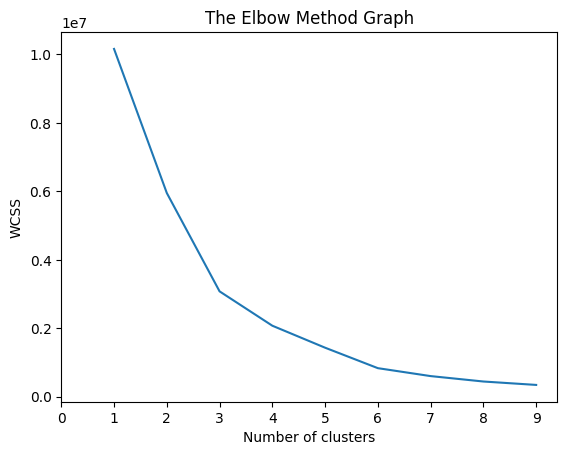

In [2]:
def elbow_diagram(data, max_clusters=8):
    wcss=[]
    for i in range(1,max_clusters): 
        kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=50,  n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,max_clusters),wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.xticks(range(max_clusters))
    plt.ylabel('WCSS')
    plt.show()

elbow_diagram(reduced, max_clusters=10)


To determine the number of clusters, we are looking for the "elbow" in this graph.  If you want to think about this more mathematically, we are interested not in the slope of the graph, but how the slope is changing, or the second derivative.  You can see that the slope starts out quite steep, changing gradually through two and three clusters.  At four clusters, the slope changes significantly.  After this, the slope does change, but the change is very gradual, headed toward a flat line.

What does this mean?  The interpretation would be that there are four, possibly three, clusters in this data.


# <img src="../images/task.png" width=20 height=20> Extra-Credit Task

In this class, you should be finding that there is an emphasis on creating systems that can make decisions without human intervention. Imagine, for a moment, that you wanted to periodically generate clusters using K-Means but want to allow the agent that you are creating to decide how many clusters are present. How can we accomplish this without a human having to select the number of clusters every time?

If you recall our discussion about the Fourier transformation, you may remember that we introduced the notion of the derivative of a function. The derivative of a function tells us the rate, or ratio, of change in `y` vs change in `x` at any given point on the output of the function; we typically think of this as slope. What if we were to take the derivative of the derivative, or the second derivative? This would tell us how the slope is changing, or the rate of change of the slope at any given point. We could then use some threshold to determine when the rate of change of the slope tells us we have found the likely number of clusters.

The WCSS data that we have in our elbow diagram, however, is connecting points. We would need to have at least a third degree polynomial to be able to take a meaningful second derivative. In practice, we want a higher degree polynomial or we could end up with some inconvenient "wiggles" in our polynomial. It turns out that there is a NumPy function that can help us out.

Your task:

 * Take some time to review the documentation for the `polyfit()` and `poly1d()` functions in NumPy.
 * Next review the documentation for `polyder()` in NumPy.
 * Using your research above write a function that:
   - Finds a eigth degree polynomial that fits the WCSS data.
   - Finds the first derivative of that polynomial.
   - Evaluates the first derivative to find the slope at each of the possible values for *n* used to create the WCSS data.
   - The number of clusters is likely to be the first value where the slope falls below -1. Return this value.

In [3]:
import warnings
# The warnings class allows us to raise and output a warning without interrupting execution.

def find_wcss_values(data, max_clusters=8):
    wcss=[]
    for i in range(1,max_clusters): 
        kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=50,  n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss
    
def find_num_clusters(data, max_clusters=8):
    wcss_values = find_wcss_values(data, max_clusters)
    wcss_values = StandardScaler().fit_transform(np.array(wcss_values).reshape(-1, 1)).reshape(-1,)
    coefficients = np.polyfit(range(1,max_clusters), wcss_values, 8)
    function = np.poly1d(coefficients)
    derivative = np.polyder(function, m=1)
    last = 0
    for i in range(1,max_clusters):
        slope = derivative(i)
        if(slope > -1):
            return i
    warnings.WarningMessage(f'There are likely more than {max_clusters} present. Consider trying again with a larger value.')
    return max_clusters


find_num_clusters(data)
 

/tmp/ipykernel_8317/325584030.py:15: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(range(1,max_clusters), wcss_values, 8)


3


# Conclusion

While the data that we have looked at in these two labs hasn't been the most interesting, we have still been able to learn some key concepts and apply them.  Additionally, we have generalized a couple of common tasks.

How could we go further?  The extra credit stop answers this question. As we have implemented it, the Elbow Method is still visual, requiring us to look at the visualization to determine the number of clusters.  Could we automate that?  Yes! Think about the line that connects two different variance plots as a slope of the inertia.  If that slope changes to a ratio where the relative change in the inertia is less than the relative change in the number of clusters, our slope has definitely begun to flatten out!